In [14]:
# Cell 1: Setup and Configuration
# --- 1. Install Libraries (Reliable Method) ---
import sys
# !{sys.executable} -m pip install pandas openpyxl matplotlib wordcloud seaborn
# !{sys.executable} -m pip install --upgrade nltk scikit-learn spacy
# !{sys.executable} -m pip install --upgrade Pillow==9.5.0

# --- 2. Import Libraries ---
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# ... (the rest of the imports from your original cell)
# ... make sure all original imports are here ...
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, bigrams, trigrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# --- 3. Download NLP Models ---
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True) # Correct
nltk.download('omw-1.4', quiet=True)
!{sys.executable} -m spacy download en_core_web_md

# --- 4. 🔴 USER CONFIGURATION 🔴 ---
EXCEL_FILE_PATH = r'D:/Z - Neverwonderland/2 - Prince Sarcawesum/1 - DESIGN\MEDIAWARE ARTS AND PRINTS/AAA_Corporate Material/Data Analysis/Verbatim Analysis/Dummy Verbatim Dataset.xlsx'
TEXT_COLUMN_NAME = 'Verbatim'
CUSTOM_STOP_WORDS = {'app', 'product', 'service', 'company'}
TOPIC_MODEL_TOPICS = 3

print("✅ Setup complete. All libraries and models are ready.")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\EJG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
✅ Setup complete. All libraries and models are ready.


Successfully loaded 50 rows from 'D:/Z - Neverwonderland/2 - Prince Sarcawesum/1 - DESIGN\MEDIAWARE ARTS AND PRINTS/AAA_Corporate Material/Data Analysis/Verbatim Analysis/Dummy Verbatim Dataset.xlsx'.

--- Data Preview with Cleaned Text and Sentiment ---


,Verbatim,cleaned_text,sentiment_label
0,"""The website was a mess, couldn't find the spe...",website mess couldnt find spec tablet wanted,Negative
1,"""My new laptop overheated almost immediately a...",new laptop overheated almost immediately turne...,Neutral
2,"""I tried to use the live chat, but no one ever...",tried use live chat one ever responded whats p...,Negative
3,"""The delivery was two days late and the box wa...",delivery two day late box dented hope inside i...,Positive
4,"""I returned a broken phone and haven't receive...",returned broken phone havent received refund y...,Negative


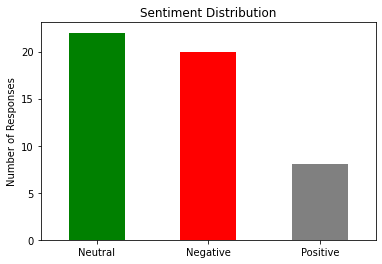

In [15]:
# Cell 2: Data Loading and Preprocessing
# --- 1. Load Data ---
try:
    df = pd.read_excel(EXCEL_FILE_PATH)
    print(f"Successfully loaded {len(df)} rows from '{EXCEL_FILE_PATH}'.")
except FileNotFoundError:
    print(f"⚠️ Warning: File not found. Loading dummy data for demonstration.")
    df = pd.DataFrame({
        TEXT_COLUMN_NAME: [
            "The customer service was excellent! Very helpful and friendly.",
            "I'm very unhappy with the new update. It's slow and buggy.",
            "It's okay, but the price is too high for what you get.",
            "Love the new design! The user interface is so much better.",
            "The app crashes all the time. Please fix this bug.",
        ]
    })
df.dropna(subset=[TEXT_COLUMN_NAME], inplace=True)

# --- 2. Text Cleaning ---
stop_words = set(stopwords.words('english')).union(CUSTOM_STOP_WORDS)
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'[\d\n]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text.strip())
    cleaned_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(cleaned_tokens)

df['cleaned_text'] = df[TEXT_COLUMN_NAME].apply(clean_text)

# --- 3. Sentiment Analysis ---
sia = SentimentIntensityAnalyzer()
df['sentiment_compound'] = df[TEXT_COLUMN_NAME].apply(lambda x: sia.polarity_scores(x)['compound'])

def categorize_sentiment(compound):
    if compound >= 0.05: return 'Positive'
    if compound <= -0.05: return 'Negative'
    return 'Neutral'

df['sentiment_label'] = df['sentiment_compound'].apply(categorize_sentiment)

print("\n--- Data Preview with Cleaned Text and Sentiment ---")
display(df[[TEXT_COLUMN_NAME, 'cleaned_text', 'sentiment_label']].head())

# --- 4. Plot Sentiment Distribution ---
plt.figure(figsize=(6, 4))
df['sentiment_label'].value_counts().plot(kind='bar', color=['green', 'red', 'grey'])
plt.title('Sentiment Distribution')
plt.ylabel('Number of Responses')
plt.xticks(rotation=0)
plt.show()

--- Top 20 Most Common Words ---
[('new', 6), ('one', 6), ('never', 5), ('sent', 5), ('item', 5), ('couldnt', 4), ('sale', 4), ('arrived', 4), ('get', 4), ('store', 4), ('find', 3), ('laptop', 3), ('tried', 3), ('two', 3), ('phone', 3), ('help', 3), ('doesnt', 3), ('return', 3), ('order', 3), ('every', 3)]


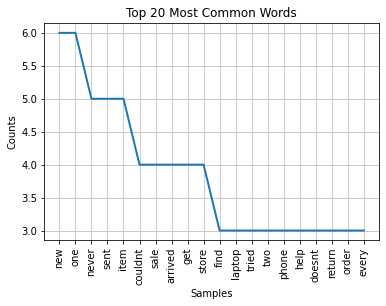

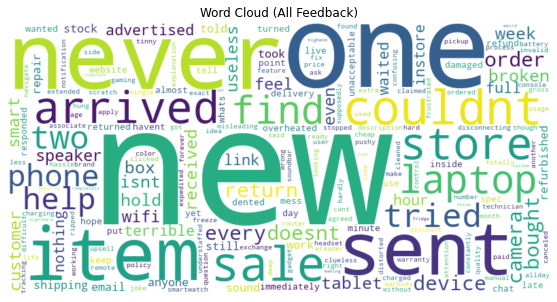

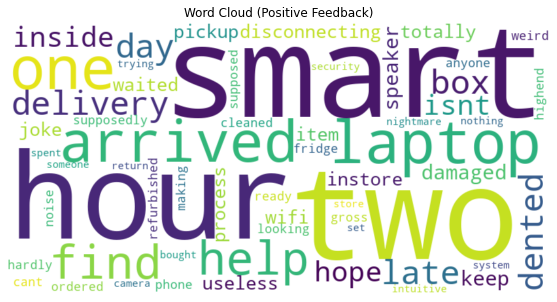

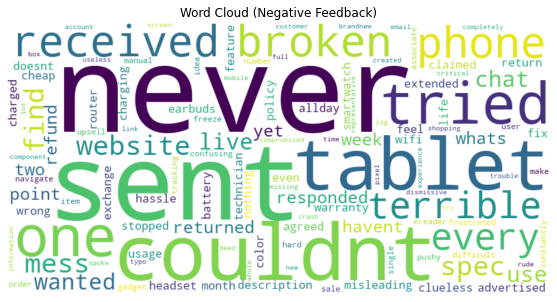

In [16]:
# Cell 3: Overall Frequency Analysis & Word Clouds
# --- 1. Prepare Overall Text and Tokens ---
all_cleaned_text = " ".join(df['cleaned_text'])
all_tokens = word_tokenize(all_cleaned_text)

# --- 2. Frequency Distribution ---
fdist = FreqDist(all_tokens)
print("--- Top 20 Most Common Words ---")
print(fdist.most_common(20))
fdist.plot(20, title='Top 20 Most Common Words')
plt.show()

# --- 3. Word Cloud Visualization ---
def generate_wordcloud(text, title):
    if not text.strip():
        print(f"Skipping '{title}' word cloud: No text available.")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate clouds for overall, positive, and negative sentiment
generate_wordcloud(all_cleaned_text, 'Word Cloud (All Feedback)')
generate_wordcloud(" ".join(df[df.sentiment_label == 'Positive']['cleaned_text']), 'Word Cloud (Positive Feedback)')
generate_wordcloud(" ".join(df[df.sentiment_label == 'Negative']['cleaned_text']), 'Word Cloud (Negative Feedback)')

In [17]:
# Cell 4: Topic Modeling (LDA)
# --- Topic Modeling using LDA ---
print("\n--- Discovering Latent Topics ---")
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_text'].dropna())

if dtm.shape[0] > 1:
    lda = LatentDirichletAllocation(n_components=TOPIC_MODEL_TOPICS, random_state=42)
    lda.fit(dtm)
    
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])
        print(f"Topic #{topic_idx + 1}: {top_words}")
else:
    print("Not enough data to perform topic modeling.")


--- Discovering Latent Topics ---
Topic #1: item store new camera hour useless broken stock waited smart
Topic #2: sent sale doesnt bought new return work shipping sound terrible
Topic #3: arrived device laptop tried order help isnt customer box tablet


In [18]:
# Cell 5: Jaccard Similarity (Between Sentiments)
# --- 1. Jaccard Similarity Analysis ---
N_WORDS, N_BIGRAMS, N_TRIGRAMS = 20, 10, 10

def get_top_ngrams(tokens, n, N_top):
    if n == 1:
        ngrams_list = tokens
    elif n == 2:
        ngrams_list = list(bigrams(tokens))
    elif n == 3:
        ngrams_list = list(trigrams(tokens))
    return [item for item, freq in FreqDist(ngrams_list).most_common(N_top)]

sentiments = ['Positive', 'Negative', 'Neutral']
tokens_by_sentiment = {s: word_tokenize(" ".join(df[df.sentiment_label == s]['cleaned_text'])) for s in sentiments}

top_words = {s: get_top_ngrams(tokens_by_sentiment[s], 1, N_WORDS) for s in sentiments}
top_bigrams = {s: get_top_ngrams(tokens_by_sentiment[s], 2, N_BIGRAMS) for s in sentiments}
top_trigrams = {s: get_top_ngrams(tokens_by_sentiment[s], 3, N_TRIGRAMS) for s in sentiments}

def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0.0

# --- 2. Display Results ---
comparisons = [("Positive", "Negative"), ("Positive", "Neutral"), ("Negative", "Neutral")]
results = {
    "Comparison": [f"{s1} vs. {s2}" for s1, s2 in comparisons],
    f"Words (Top {N_WORDS})": [jaccard_similarity(top_words[s1], top_words[s2]) for s1, s2 in comparisons],
    f"Bigrams (Top {N_BIGRAMS})": [jaccard_similarity(top_bigrams[s1], top_bigrams[s2]) for s1, s2 in comparisons],
    f"Trigrams (Top {N_TRIGRAMS})": [jaccard_similarity(top_trigrams[s1], top_trigrams[s2]) for s1, s2 in comparisons]
}

print("\n--- Vocabulary Similarity Between Sentiments ---")
display(pd.DataFrame(results).round(3))


--- Vocabulary Similarity Between Sentiments ---


,Comparison,Words (Top 20),Bigrams (Top 10),Trigrams (Top 10)
0,Positive vs. Negative,0.053,0.0,0.0
1,Positive vs. Neutral,0.053,0.0,0.0
2,Negative vs. Neutral,0.053,0.0,0.0



--- Calculating Inter-Item Similarity ---


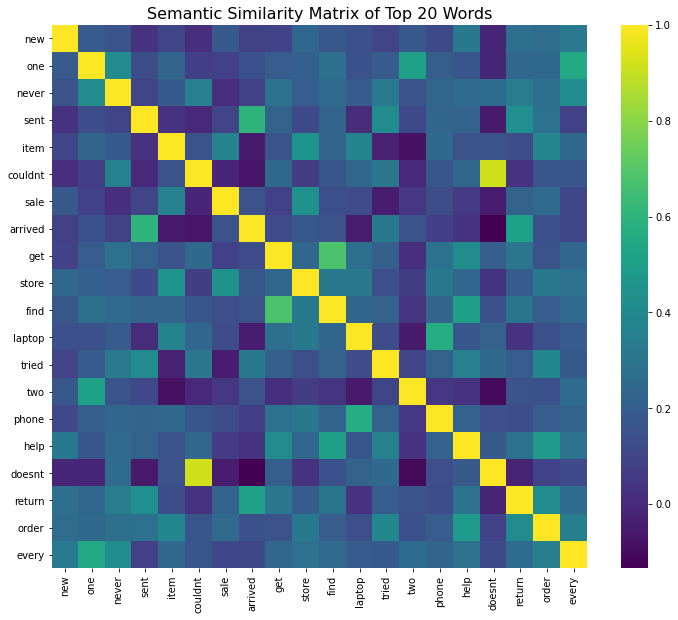

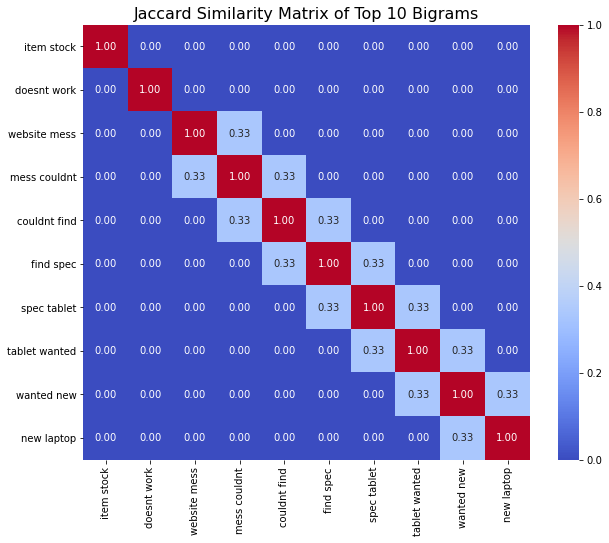

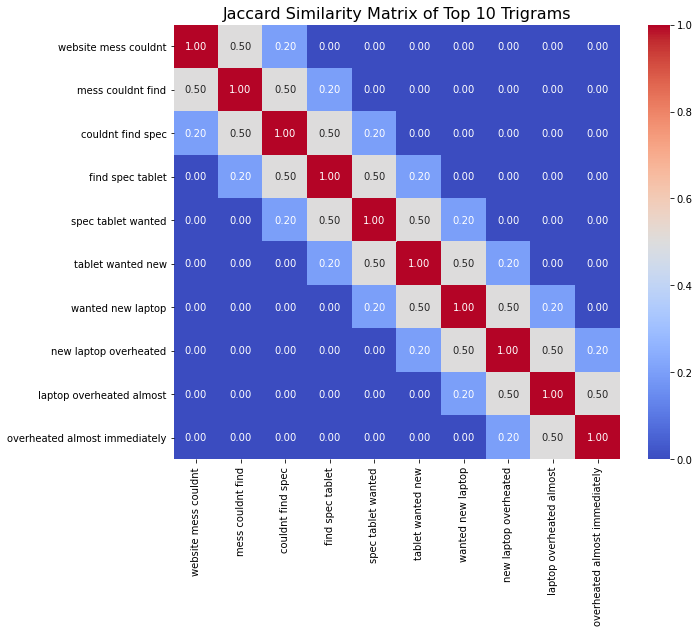


--- Analysis Complete ---


In [19]:
# Cell 6: Inter-Item Similarity (Heatmaps)
# --- 1. Load spaCy Model ---
try:
    nlp = spacy.load("en_core_web_md")
    print("\n--- Calculating Inter-Item Similarity ---")
except OSError:
    print("spaCy model not found. Please run Cell 1 to download.")
    nlp = None

if nlp:
    # --- 2. Semantic Similarity for Words ---
    top_words_overall = get_top_ngrams(all_tokens, 1, 20)
    similarity_matrix = np.array([[nlp(w1).similarity(nlp(w2)) for w2 in top_words_overall] for w1 in top_words_overall])
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(pd.DataFrame(similarity_matrix, index=top_words_overall, columns=top_words_overall), cmap='viridis')
    plt.title('Semantic Similarity Matrix of Top 20 Words', fontsize=16)
    plt.show()

    # --- 3. Jaccard Similarity for N-Grams ---
    def plot_ngram_heatmap(ngrams, n_val):
        labels = [' '.join(gram) for gram in ngrams]
        matrix = np.array([[jaccard_similarity(list(g1), list(g2)) for g2 in ngrams] for g1 in ngrams])
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pd.DataFrame(matrix, index=labels, columns=labels), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f'Jaccard Similarity Matrix of Top {len(ngrams)} {"Bigrams" if n_val==2 else "Trigrams"}', fontsize=16)
        plt.show()

    plot_ngram_heatmap(get_top_ngrams(all_tokens, 2, 10), 2)
    plot_ngram_heatmap(get_top_ngrams(all_tokens, 3, 10), 3)

print("\n--- Analysis Complete ---")